In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import squeezenet1_0, resnet18
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
from PIL import Image

drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
!pip install torchattack

In [74]:
from torchattack import PGD

In [75]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5); self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120); self.fc2 = nn.Linear(120, 84); self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x)); x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x)); x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1); x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x)); return self.fc3(x)

class SqueezeNetMNIST(nn.Module):
    def __init__(self):
        super(SqueezeNetMNIST, self).__init__()
        self.model = squeezenet1_0(num_classes=10)
        self.model.classifier[1] = nn.Conv2d(512, 10, kernel_size=1)
    def forward(self, x):
        if x.shape[1] == 1: x = x.repeat(1, 3, 1, 1)
        return self.model(x)

class ResNet18MNIST(nn.Module):
    def __init__(self):
        super(ResNet18MNIST, self).__init__()
        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    def forward(self, x):
        return self.model(x)

class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)
    def forward(self, x):
        x = self.flatten(x)
        return self.linear(x)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class ConvNetTiny(nn.Module):
    def __init__(self):
        super(ConvNetTiny, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.fc1 = nn.Linear(8 * 13 * 13, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class ConvNetWide(nn.Module):
    def __init__(self):
        super(ConvNetWide, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class ConvNetDeep(nn.Module):
    def __init__(self):
        super(ConvNetDeep, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(64 * 3 * 3, 10)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

class MiniGoogLeNet(nn.Module):
    def __init__(self):
        super(MiniGoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.inception = InceptionModule(64, 16, 32, 24, 8, 8, 16)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)
    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class MiniDenseNet(nn.Module):
    def __init__(self):
        super(MiniDenseNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(16 * 14 * 14, 10)
    def forward(self, x):
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(out1))
        c2 = torch.cat([out1, out2], 1)
        out3 = F.relu(self.conv3(c2))
        x = self.pool(out3)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [76]:
model_configs = []

model_configs.append(('LeNet_Standard', 'lenet.pth', LeNet5))
model_configs.append(('LeNet_Robust', 'lenet_robust.pth', LeNet5))
model_configs.append(('Squeeze_Standard', 'squeezenet.pth', SqueezeNetMNIST))
model_configs.append(('Squeeze_Robust', 'squeezenet_robust.pth', SqueezeNetMNIST))

zoo_architectures = [
    ('Linear', LinearModel), ('MLP', MLP), ('ConvTiny', ConvNetTiny),
    ('Simple', SimpleCNN), ('ConvWide', ConvNetWide), ('ConvDeep', ConvNetDeep),
    ('LeNet', LeNet5), ('MiniVGG', MiniVGG), ('Squeeze', SqueezeNetMNIST),
    ('MiniInception', MiniGoogLeNet), ('MiniDense', MiniDenseNet), ('ResNet', ResNet18MNIST)
]

for seed in range(2):
    for name, arch_cls in zoo_architectures:
        model_configs.append((f"{name}_s{seed}", f"{name.lower()}_s{seed}.pth", arch_cls))

focus_models_names = ['LeNet_Standard', 'LeNet_Robust', 'Squeeze_Standard', 'Squeeze_Robust']

In [77]:
base_path = '/content/drive/My Drive/adversarial_mnist'
weights_dir = f'{base_path}/model_weights'
adv_dir = f'{base_path}/large_adversarial_examples'
external_data_path = f'{base_path}/external_data/test/pgd'

zoo_models = {}
for name, fname, arch_cls in model_configs:
    path = f"{weights_dir}/{fname}"
    m = arch_cls()
    m.load_state_dict(torch.load(path, map_location=device))
    m.to(device).eval()
    zoo_models[name] = m

In [78]:
external_data_path = '/content/drive/My Drive/adversarial_mnist/external_dataset/test/pgd'

def load_external_dataset(folder_path):
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Directory not found: {folder_path}")

    print(f"Loading from: {folder_path}")

    all_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

    if not all_files:
        raise FileNotFoundError(f"No image files found in {folder_path}")

    transform = transforms.Compose([transforms.ToTensor()])

    mnist_test = datasets.MNIST(root='./data', train=False, download=True)
    labels = mnist_test.targets

    images = []
    limit = min(len(all_files), len(labels))

    print(f"Found {len(all_files)} images. Loading {limit}...")

    for i in range(limit):
        img_path = os.path.join(folder_path, all_files[i])
        img = Image.open(img_path).convert('L')
        images.append(transform(img))

    print(f"Successfully loaded {len(images)} images.")
    return torch.stack(images), labels[:len(images)]

ext_imgs, ext_lbls = load_external_dataset(external_data_path)

Loading from: /content/drive/My Drive/adversarial_mnist/external_dataset/test/pgd
Found 1000 images. Loading 1000...
Successfully loaded 1000 images.


In [80]:
all_names = [c[0] for c in model_configs]
n_models = len(all_names)
matrix_acc = np.zeros((n_models, n_models))
matrix_pert = np.zeros((n_models, n_models))

adv_datasets = {}

for name, fname, _ in model_configs:
    path = f"{adv_dir}/500_adv_{fname}"
    adv_datasets[name] = torch.load(path)

for i, src_name in enumerate(all_names):
    src_data = adv_datasets[src_name]
    adv_imgs = src_data['adv'].to(device)
    lbls = src_data['lbl'].to(device)

    clean_imgs = None
    if 'clean' in src_data:
        clean_imgs = src_data['clean'].to(device)

    for j, tgt_name in enumerate(all_names):
        model = zoo_models[tgt_name]
        with torch.no_grad():
            preds = model(adv_imgs).argmax(1)

            acc = (preds == lbls).float().mean().item() * 100
            matrix_acc[i, j] = acc

            if clean_imgs is not None:
                success_indices = (preds != lbls)
                if success_indices.sum() > 0:
                    diff = adv_imgs[success_indices] - clean_imgs[success_indices]
                    norms = diff.view(diff.size(0), -1).norm(p=2, dim=1)
                    avg_pert = norms.mean().item()
                    matrix_pert[i, j] = avg_pert

In [81]:
focus_indices = [all_names.index(n) for n in focus_models_names]

clean_accs = []
whitebox_accs = []
zoo_defense_scores = []
zoo_offense_scores = []
avg_pert_scores = []
blackbox_accs = []

for idx in focus_indices:
    name = all_names[idx]
    data = adv_datasets[name]

    clean_accs.append(data['score_clean'])
    whitebox_accs.append(data['score_robust'])

    incoming_attacks = [matrix_acc[i, idx] for i in range(n_models) if i != idx]
    zoo_defense_scores.append(np.mean(incoming_attacks))

    outgoing_attacks = [100 - matrix_acc[idx, j] for j in range(n_models) if j != idx]
    zoo_offense_scores.append(np.mean(outgoing_attacks))

    incoming_perts = [matrix_pert[i, idx] for i in range(n_models) if matrix_pert[i, idx] > 0]
    avg_pert_scores.append(np.mean(incoming_perts))

    with torch.no_grad():
        preds = zoo_models[name](ext_imgs.to(device)).argmax(1)
        acc = (preds == ext_lbls.to(device)).float().mean().item() * 100
    blackbox_accs.append(acc)

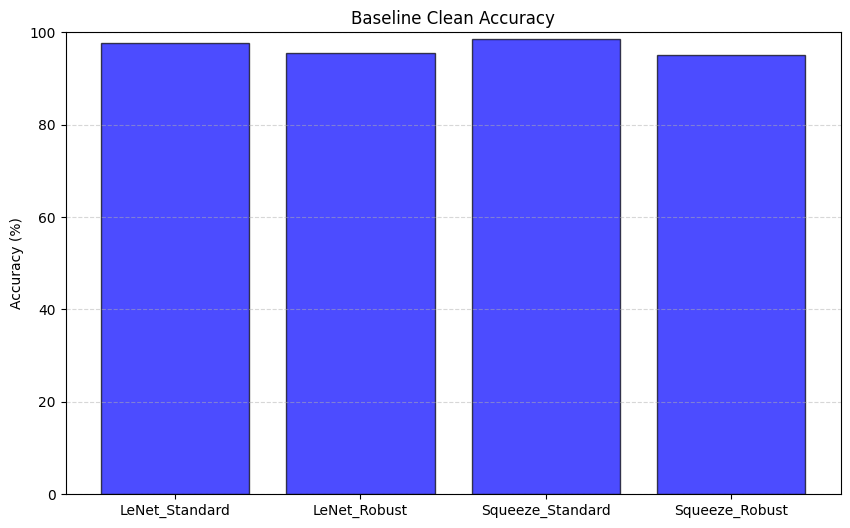

Baseline Clean Accuracy:
LeNet_Standard: 97.65%
LeNet_Robust: 95.40%
Squeeze_Standard: 98.44%
Squeeze_Robust: 95.04%


In [82]:
x = np.arange(len(focus_models_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, clean_accs, color='blue', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("Baseline Clean Accuracy")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Baseline Clean Accuracy:")
for n, c in zip(focus_models_names, clean_accs):
    print(f"{n}: {c:.2f}%")

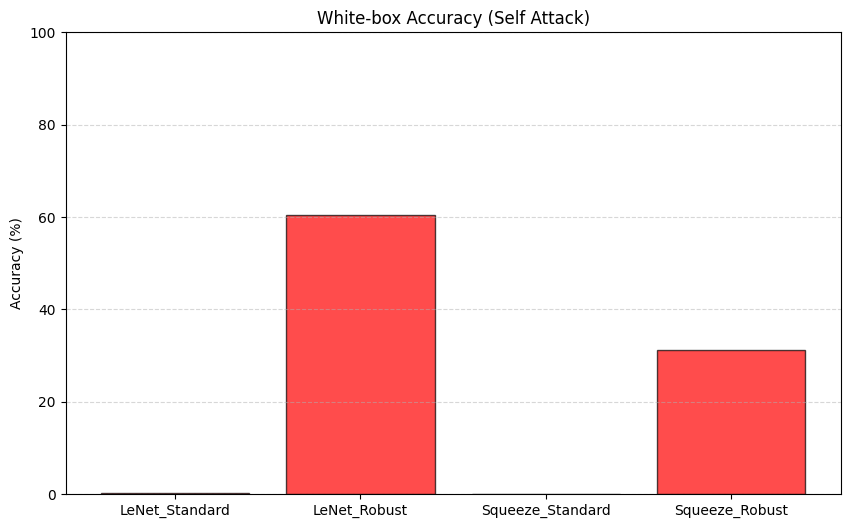

White-box Accuracy:
LeNet_Standard: 0.18%
LeNet_Robust: 60.46%
Squeeze_Standard: 0.01%
Squeeze_Robust: 31.23%


In [83]:
plt.figure(figsize=(10, 6))
plt.bar(x, whitebox_accs, color='red', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("White-box Accuracy (Self Attack)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("White-box Accuracy:")
for n, w in zip(focus_models_names, whitebox_accs):
    print(f"{n}: {w:.2f}%")

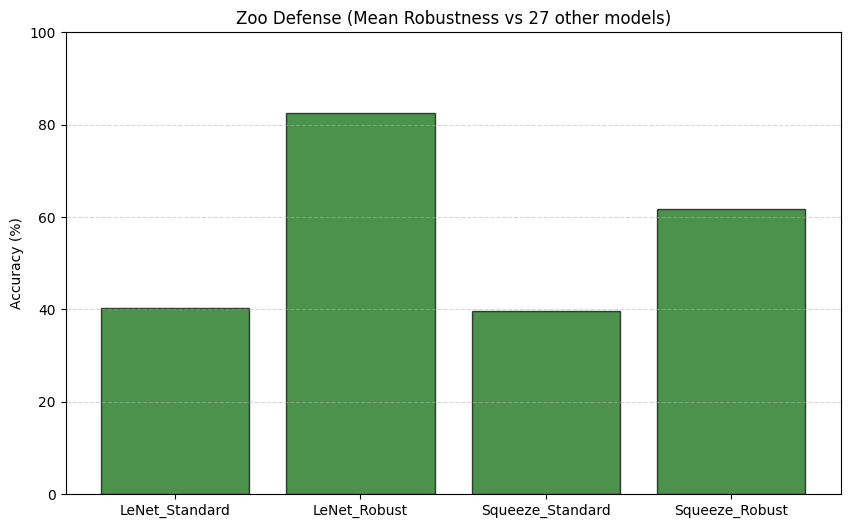

Zoo Defense Score:
LeNet_Standard: 40.30%
LeNet_Robust: 82.47%
Squeeze_Standard: 39.59%
Squeeze_Robust: 61.70%


In [84]:
plt.figure(figsize=(10, 6))
plt.bar(x, zoo_defense_scores, color='darkgreen', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title(f"Zoo Defense (Mean Robustness vs {n_models-1} other models)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Zoo Defense Score:")
for n, d in zip(focus_models_names, zoo_defense_scores):
    print(f"{n}: {d:.2f}%")

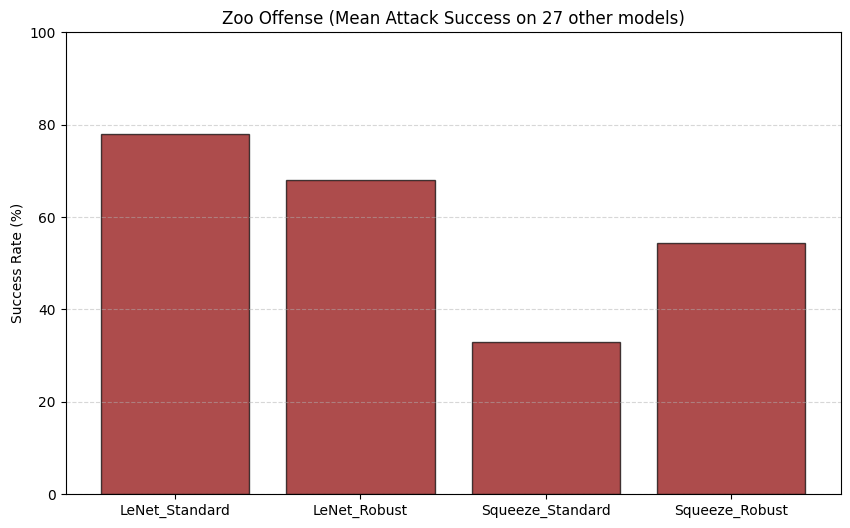

Zoo Offense Score:
LeNet_Standard: 77.87%
LeNet_Robust: 67.91%
Squeeze_Standard: 32.93%
Squeeze_Robust: 54.47%


In [85]:
plt.figure(figsize=(10, 6))
plt.bar(x, zoo_offense_scores, color='darkred', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Success Rate (%)")
plt.title(f"Zoo Offense (Mean Attack Success on {n_models-1} other models)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Zoo Offense Score:")
for n, o in zip(focus_models_names, zoo_offense_scores):
    print(f"{n}: {o:.2f}%")

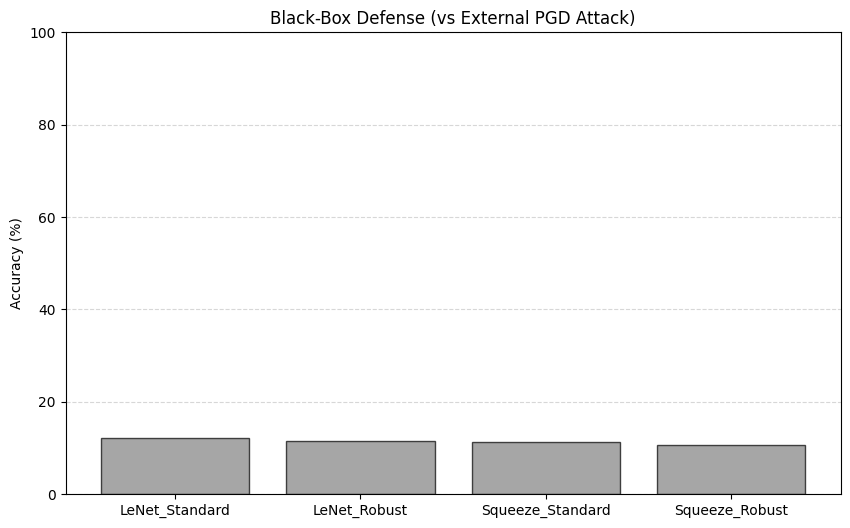

Black-Box Defense Data:
LeNet_Standard: 12.10%
LeNet_Robust: 11.40%
Squeeze_Standard: 11.30%
Squeeze_Robust: 10.70%


In [86]:
plt.figure(figsize=(10, 6))
plt.bar(x, blackbox_accs, color='gray', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("Black-Box Defense (vs External PGD Attack)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Black-Box Defense Data:")
for n, s in zip(focus_models_names, blackbox_accs):
    print(f"{n}: {s:.2f}%")

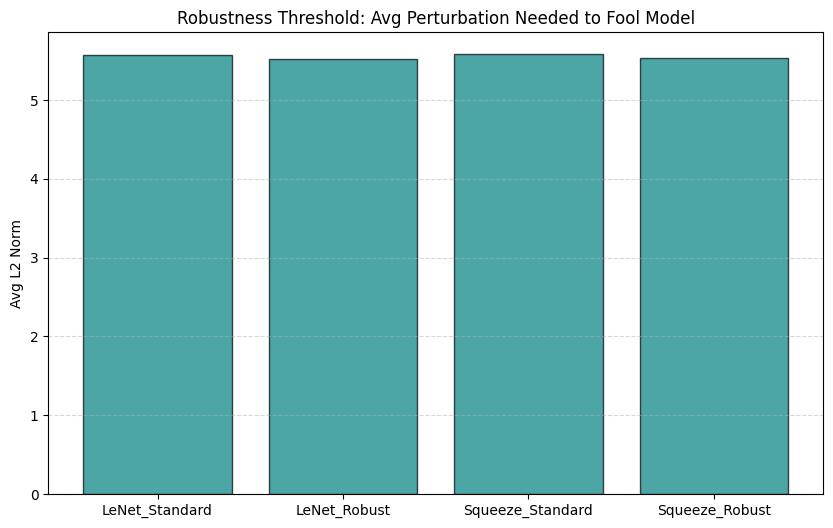

Avg Perturbation Data:
LeNet_Standard: 5.5683
LeNet_Robust: 5.5150
Squeeze_Standard: 5.5794
Squeeze_Robust: 5.5366


In [87]:
plt.figure(figsize=(10, 6))
plt.bar(x, avg_pert_scores, color='teal', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Avg L2 Norm")
plt.title("Robustness Threshold: Avg Perturbation Needed to Fool Model")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Avg Perturbation Data:")
for n, p in zip(focus_models_names, avg_pert_scores):
    print(f"{n}: {p:.4f}")

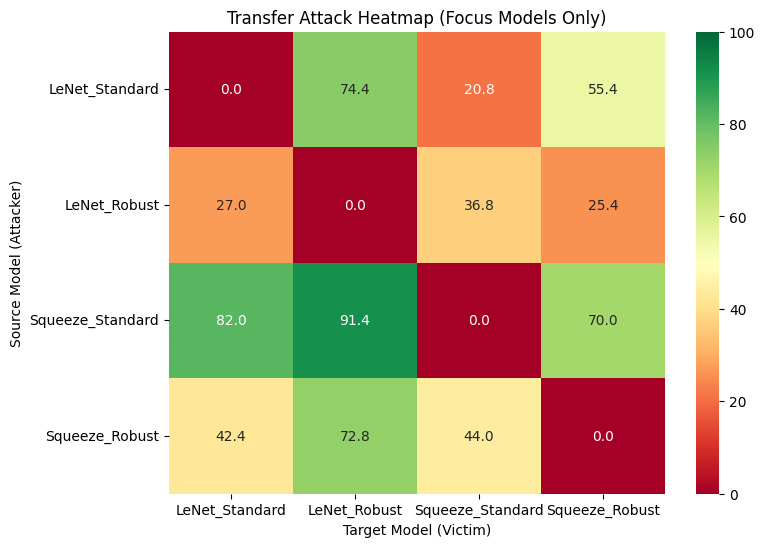

In [88]:
focus_matrix = matrix_acc[np.ix_(focus_indices, focus_indices)]

plt.figure(figsize=(8, 6))
sns.heatmap(focus_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
            xticklabels=focus_models_names, yticklabels=focus_models_names)
plt.title("Transfer Attack Heatmap (Focus Models Only)")
plt.ylabel("Source Model (Attacker)")
plt.xlabel("Target Model (Victim)")
plt.show()